# Multi Resolution Simulation

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# plt.rcParams["lines.color"] = "w"
# plt.rcParams["text.color"] = "w"
# plt.rcParams["axes.labelcolor"] = "w"
# plt.rcParams["xtick.color"] = "w"
# plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, Common, WindStress
from gpuocean.SWEsimulators import CDKLM16

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
# %% 
import datetime
timestamp = datetime.datetime.now().strftime("%Y-%m-%dT%H_%M_%S")

if not os.path.exists("DAoutput"):
    os.makedirs("DAoutput")
log_f = open('DAoutput/log_'+timestamp+'.txt', 'w')

def log2file(file, string):
    file.write(string)
    print(string)

log2file(log_f, timestamp + ': Staring ML-DA simulation'+'\n')


2023-02-28T09_44_12: Staring ML-DA simulation



Rossby utils

In [5]:
# %%
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
sys.path.insert(0, "/home/florianb/havvarsel/multilevelDA/")
from utils.RossbyInit import *
from utils.WindPerturb import *


In [6]:
wind_N = 100
t_splits = 26

In [7]:
KLSampler = KarhunenLoeve_Sampler(t_splits + 3, wind_N)
wind_weight = wind_bump(KLSampler.N,KLSampler.N)

## Data Assimilation


In [8]:
from skimage.measure import block_reduce

In [9]:
def imshow3(etahuhv):
    fig, axs = plt.subplots(1,3, figsize=(15,10))
    im = axs[0].imshow(etahuhv[0], vmin=-0.05, vmax=0.05, cmap="coolwarm")
    plt.colorbar(im, ax=axs[0], shrink=0.5)
    axs[0].set_title("$\eta$", fontsize=15)

    im = axs[1].imshow(etahuhv[1], vmin=-1, vmax=1, cmap="coolwarm")
    plt.colorbar(im, ax=axs[1], shrink=0.5)
    axs[1].set_title("$hu$", fontsize=15)

    im = axs[2].imshow(etahuhv[2], vmin=-1, vmax=1, cmap="coolwarm")
    plt.colorbar(im, ax=axs[2], shrink=0.5)
    axs[2].set_title("$hv$", fontsize=15)

    return fig, axs


def imshow3var(est_var):
    fig, axs = plt.subplots(1,3, figsize=(15,10))
    im = axs[0].imshow(est_var[0], vmin=0.0, vmax=0.0001, cmap="Reds")
    plt.colorbar(im, ax=axs[0], shrink=0.5)
    axs[0].set_title("$\eta$", fontsize=15)

    im = axs[1].imshow(est_var[1], vmin=0, vmax=0.5, cmap="Reds")
    plt.colorbar(im, ax=axs[1], shrink=0.5)
    axs[1].set_title("$hu$", fontsize=15)

    im = axs[2].imshow(est_var[2], vmin=0, vmax=0.5, cmap="Reds")
    plt.colorbar(im, ax=axs[2], shrink=0.5)
    axs[2].set_title("$hv$", fontsize=15)

    return fig, axs


In [10]:
ls = [6, 7, 8, 9, 10]
T = 250000


### Variance-level analysis

In [11]:

vars = np.load("../scripts/OutputVarianceLevels/Rossby-vars-SpaceTimeWind.npy")
diff_vars = np.load("../scripts/OutputVarianceLevels/Rossby-diff_vars-SpaceTimeWind.npy")

# Use the "worst" variable 
vars_hv = vars[:,2]
diff_vars_hv = diff_vars[:,2]

# %%
def level_work(l):
    # Cubic work in terms of grid size: 2-space + 1-time
    return (2**(l+1))*(2**l)*(2**l)

# %%
allwork = 0
for l_idx, l in enumerate(ls):
    if l_idx == 0: 
        allwork += np.sqrt(vars_hv[l_idx] * level_work(l))
    else:
        allwork += np.sqrt(diff_vars_hv[l_idx] * level_work(l))

optNe_ref = np.zeros(len(ls))
for l_idx, l in enumerate(ls):
    if l_idx == 0: 
        optNe_ref[l_idx] = np.sqrt(vars_hv[l_idx]/((2**l)**2)) * allwork
    else: 
        optNe_ref[l_idx] = np.sqrt(diff_vars_hv[l_idx]/((2**l)**2)) * allwork


In [12]:
tau = 0.05
Nes = np.int32(np.ceil(1/(tau**2)*optNe_ref))

In [13]:
SL_Ne = int(np.sum([level_work(l) for l in ls] * np.array(Nes))/level_work(ls[-1]))

### Util functions

In [14]:
def generate_truth():
    data_args = initLevel(ls[-1])
    true_wind = wind_sample(KLSampler, T + 30000, wind_weight=wind_weight)
    truth = CDKLM16.CDKLM16(gpu_ctx, **data_args, wind=true_wind)
    truth.step(T)

    return truth

def generate_obs_from_truth(truth, Hy, Hx, R):
    true_eta, true_hu, true_hv = truth.download(interior_domain_only=True)

    Hfield = np.zeros((truth.ny,truth.nx))
    
    Hfield[Hy,Hx] = 1.0

    obs = [true_eta[Hy,Hx], true_hu[Hy,Hx], true_hv[Hy,Hx]] + np.random.normal(0,R)

    return obs

Hy, Hx = 800, 600
R = [0.0001, 0.01, 0.01]

In [15]:
def MLinit(Nes):
    ML_ensemble = []

    lvl_ensemble = []
    data_args = initLevel(ls[0])
    for e in range(Nes[0]):
        # log2file(log_f, datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%S") + "Level 0, memeber " + str(e) +"\n")
        wind = wind_sample(KLSampler, T + 30000, wind_weight=wind_weight)
        lvl_ensemble.append(CDKLM16.CDKLM16(gpu_ctx, **data_args, wind=wind))

    ML_ensemble.append(lvl_ensemble)
        

    for l_idx in range(1,len(Nes)):
        lvl_ensemble0 = []
        lvl_ensemble1 = []
        
        data_args0 = initLevel(ls[l_idx])
        data_args1 = initLevel(ls[l_idx-1])
        
        for e in range(Nes[l_idx]):
            # log2file(log_f, datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%S") + "Level "+str(l_idx)+", memeber " + str(e) +"\n")
            wind = wind_sample(KLSampler, T + 30000, wind_weight=wind_weight)
            
            lvl_ensemble0.append(CDKLM16.CDKLM16(gpu_ctx, **data_args0, wind=wind))
            lvl_ensemble1.append(CDKLM16.CDKLM16(gpu_ctx, **data_args1, wind=wind))
        
        ML_ensemble.append([lvl_ensemble0,lvl_ensemble1])
    return ML_ensemble


In [16]:
def MLstepping(ML_ensemble, T):
    for e in range(Nes[0]):
        # log2file(log_f, datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%S") + "Level 0, memeber " + str(e) +"\n")
        ML_ensemble[0][e].step(T)
        
    for l_idx in range(1,len(Nes)):
        for e in range(Nes[l_idx]):
            # log2file(log_f, datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%S") + "Level "+str(l_idx)+", memeber " + str(e) +"\n")
            ML_ensemble[l_idx][0][e].step(T)
            ML_ensemble[l_idx][1][e].step(T)

In [17]:
def MLdownload(ML_ensemble):
    ML_state = []

    lvl_state = []
    for e in range(Nes[0]):
        eta, hu, hv = ML_ensemble[0][e].download(interior_domain_only=True)
        lvl_state.append(np.array([eta, hu, hv]))
    ML_state.append(np.array(lvl_state))
    ML_state[0] = np.moveaxis(ML_state[0], 0, -1)

    for l_idx in range(1,len(Nes)):
        lvl_state0 = []
        lvl_state1 = []
        for e in range(Nes[l_idx]):
            eta0, hu0, hv0 = ML_ensemble[l_idx][0][e].download(interior_domain_only=True)
            eta1, hu1, hv1 = ML_ensemble[l_idx][1][e].download(interior_domain_only=True)
            lvl_state0.append(np.array([eta0, hu0, hv0]))
            lvl_state1.append(np.array([eta1, hu1, hv1]))
        ML_state.append([np.array(lvl_state0), np.array(lvl_state1)])
        ML_state[l_idx][0] = np.moveaxis(ML_state[l_idx][0], 0, -1)
        ML_state[l_idx][1] = np.moveaxis(ML_state[l_idx][1], 0, -1) 

    return ML_state

In [18]:
def MLEnKF(ML_ensemble, ML_state, Hx, Hy, obs, R, r = 2.5*1e7, relax_factor = 1.0):
    ## Localisation
    Xs = np.linspace(0, ML_ensemble[-1][0][0].nx * ML_ensemble[-1][0][0].dx, ML_ensemble[-1][0][0].nx)
    Ys = np.linspace(0, ML_ensemble[-1][0][0].ny * ML_ensemble[-1][0][0].dy, ML_ensemble[-1][0][0].ny)
    X, Y = np.meshgrid(Xs, Ys)

    obs_loc = np.zeros(2)
    obs_loc[0] = X[0,Hx]
    obs_loc[1] = Y[Hy,0]
    dists = np.sqrt((X - obs_loc[0])**2 + (Y - obs_loc[1])**2)

    GC = np.zeros_like(dists)
    for i in range(dists.shape[0]):
        for j in range(dists.shape[1]):
            dist = dists[i,j]
            if dist/r < 1: 
                GC[i,j] = 1 - 5/3*(dist/r)**2 + 5/8*(dist/r)**3 + 1/2*(dist/r)**4 - 1/4*(dist/r)**5
            elif dist/r >= 1 and dist/r < 2:
                GC[i,j] = 4 - 5*(dist/r) + 5/3*(dist/r)**2 + 5/8*(dist/r)**3 -1/2*(dist/r)**4 + 1/12*(dist/r)**5 - 2/(3*(dist/r))

    ## Perturbations
    ML_perts = []
    for l_idx in range(len(ls)):
        ML_perts.append(np.random.multivariate_normal(np.zeros(3), np.diag(R), size=Nes[l_idx]))

    ## Analysis
    ML_XY = np.zeros((np.prod(ML_state[-1][0].shape[:-1]),3))

    lvl_Xs = np.linspace(0, ML_ensemble[0][0].nx * ML_ensemble[0][0].dx, ML_ensemble[0][0].nx)
    lvl_Ys = np.linspace(0, ML_ensemble[0][0].ny * ML_ensemble[0][0].dy, ML_ensemble[0][0].ny)
    lvl_X, lvl_Y = np.meshgrid(lvl_Xs, lvl_Ys)

    obs_idxs = np.unravel_index(np.argmin((lvl_X - X[0,Hx])**2 + (lvl_Y - Y[Hy,0])**2), ML_state[0][0].shape[:-1])

    X0 = ML_state[0]
    X0mean = np.average(X0, axis=-1)

    Y0 = ML_state[0][:,obs_idxs[0],obs_idxs[1]] + ML_perts[0].T
    Y0mean = np.average(Y0, axis=-1)

    lvl_weight = relax_factor * np.ones(np.prod(X0mean.shape))

    ML_XY += (lvl_weight[:,np.newaxis]*1/Nes[0]*((X0-X0mean[:,:,:,np.newaxis]).reshape(-1,X0.shape[-1]) @ (Y0 - Y0mean[:,np.newaxis]).T)).reshape(X0mean.shape + (3,)).repeat(2**(ls[-1]-ls[0]),1).repeat(2**(ls[-1]-ls[0]),2).reshape(-1,ML_XY.shape[-1])

    for l_idx in range(1,len(ls)):
        l = ls[l_idx]

        lvl_Xs0 = np.linspace(0, ML_ensemble[l_idx][0][0].nx * ML_ensemble[l_idx][0][0].dx, ML_ensemble[l_idx][0][0].nx)
        lvl_Ys0 = np.linspace(0, ML_ensemble[l_idx][0][0].ny * ML_ensemble[l_idx][0][0].dy, ML_ensemble[l_idx][0][0].ny)
        lvl_X0, lvl_Y0 = np.meshgrid(lvl_Xs0, lvl_Ys0)
        obs_idxs0 = np.unravel_index(np.argmin((lvl_X0 - X[0,Hx])**2 + (lvl_Y0 - Y[Hy,0])**2), ML_state[l_idx][0][0].shape[:-1])

        lvl_Xs1 = np.linspace(0, ML_ensemble[l_idx][1][0].nx * ML_ensemble[l_idx][1][0].dx, ML_ensemble[l_idx][1][0].nx)
        lvl_Ys1 = np.linspace(0, ML_ensemble[l_idx][1][0].ny * ML_ensemble[l_idx][1][0].dy, ML_ensemble[l_idx][1][0].ny)
        lvl_X1, lvl_Y1 = np.meshgrid(lvl_Xs1, lvl_Ys1)
        obs_idxs1 = np.unravel_index(np.argmin((lvl_X1 - X[0,Hx])**2 + (lvl_Y1 - Y[Hy,0])**2), ML_state[l_idx][1][0].shape[:-1])

        X0 = ML_state[l_idx][0]
        X0mean = np.average(X0, axis=-1)
        X1 = ML_state[l_idx][1].repeat(2,1).repeat(2,2)
        X1mean = np.average(X1, axis=-1)

        Y0 = ML_state[l_idx][0][:,obs_idxs0[0],obs_idxs0[1]] + ML_perts[l_idx].T
        Y0mean = np.average(Y0, axis=-1)
        Y1 = ML_state[l_idx][1][:,obs_idxs1[0],obs_idxs1[1]] + ML_perts[l_idx].T
        Y1mean = np.average(Y1, axis=-1)

        lvl_weight = relax_factor * np.tile(block_reduce(GC, block_size=(2**(ls[-1]-l),2**(ls[-1]-l)), func=np.mean).flatten(),3)

        ML_XY += (lvl_weight[:,np.newaxis] * ( 1/Nes[l_idx]*((X0-X0mean[:,:,:,np.newaxis]).reshape(-1,X0.shape[-1]) @ (Y0 - Y0mean[:,np.newaxis]).T) - 1/Nes[l_idx]*((X1-X1mean[:,:,:,np.newaxis]).reshape(-1,X1.shape[-1]) @ (Y1 - Y1mean[:,np.newaxis]).T) )).reshape(X0mean.shape + (3,)).repeat(2**(ls[-1]-l),1).repeat(2**(ls[-1]-l),2).reshape(-1,ML_XY.shape[-1])

    ML_HXY = ML_XY.reshape(ML_state[-1][0].shape[:-1] + (3,))[:,obs_idxs0[0],obs_idxs0[1],:]
    ML_YY  = ML_HXY + np.diag(R)

    ML_K = ML_XY @ np.linalg.inv(ML_YY)

    ## Update
    lvl_Xs = np.linspace(0, ML_ensemble[0][0].nx * ML_ensemble[0][0].dx, ML_ensemble[0][0].nx)
    lvl_Ys = np.linspace(0, ML_ensemble[0][0].ny * ML_ensemble[0][0].dy, ML_ensemble[0][0].ny)
    lvl_X, lvl_Y = np.meshgrid(lvl_Xs, lvl_Ys)

    obs_idxs = np.unravel_index(np.argmin((lvl_X - X[0,Hx])**2 + (lvl_Y - Y[Hy,0])**2), ML_state[0][0].shape[:-1])

    ML_state[0] = ML_state[0] + (block_reduce( ML_K.reshape(ML_state[-1][0].shape[:-1]+ (3,)),  block_size=(1,2**(ls[-1]-ls[0]), 2**(ls[-1]-ls[0]), 1), func=np.mean).reshape((np.prod(ML_state[0].shape[:-1]),3)) @ (obs[:,np.newaxis] - ML_state[0][:,obs_idxs[0],obs_idxs[1]] - ML_perts[0].T)).reshape(ML_state[0].shape)

    for l_idx in range(1,len(ls)):
        l = ls[l_idx]

        lvl_Xs0 = np.linspace(0, ML_ensemble[l_idx][0][0].nx * ML_ensemble[l_idx][0][0].dx, ML_ensemble[l_idx][0][0].nx)
        lvl_Ys0 = np.linspace(0, ML_ensemble[l_idx][0][0].ny * ML_ensemble[l_idx][0][0].dy, ML_ensemble[l_idx][0][0].ny)
        lvl_X0, lvl_Y0 = np.meshgrid(lvl_Xs0, lvl_Ys0)
        obs_idxs0 = np.unravel_index(np.argmin((lvl_X0 - X[0,Hx])**2 + (lvl_Y0 - Y[Hy,0])**2), ML_state[l_idx][0][0].shape[:-1])

        lvl_Xs1 = np.linspace(0, ML_ensemble[l_idx][1][0].nx * ML_ensemble[l_idx][1][0].dx, ML_ensemble[l_idx][1][0].nx)
        lvl_Ys1 = np.linspace(0, ML_ensemble[l_idx][1][0].ny * ML_ensemble[l_idx][1][0].dy, ML_ensemble[l_idx][1][0].ny)
        lvl_X1, lvl_Y1 = np.meshgrid(lvl_Xs1, lvl_Ys1)
        obs_idxs1 = np.unravel_index(np.argmin((lvl_X1 - X[0,Hx])**2 + (lvl_Y1 - Y[Hy,0])**2), ML_state[l_idx][1][0].shape[:-1])

        ML_state[l_idx][0] = ML_state[l_idx][0] + block_reduce((ML_K @ (obs[:,np.newaxis] - ML_state[l_idx][0][:,obs_idxs0[0],obs_idxs0[1]] - ML_perts[l_idx].T)).reshape(ML_state[-1][0].shape[:-1]+(Nes[l_idx],)), block_size=(1,2**(ls[-1]-l), 2**(ls[-1]-l), 1), func=np.mean)
        ML_state[l_idx][1] = ML_state[l_idx][1] + block_reduce((ML_K @ (obs[:,np.newaxis] - ML_state[l_idx][1][:,obs_idxs1[0],obs_idxs1[1]] - ML_perts[l_idx].T)).reshape(ML_state[-1][0].shape[:-1]+(Nes[l_idx],)), block_size=(1,2**(ls[-1]-l+1), 2**(ls[-1]-l+1), 1), func=np.mean)

    return ML_state



In [19]:
def MLupload(ML_ensemble, ML_state):
    for e in range(Nes[0]):
        # log2file(log_f, datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%S") + "Level 0, memeber " + str(e) +"\n")
        ML_ensemble[0][e].upload(*np.pad(ML_state[0][:,:,:,e],((0,0),(2,2),(2,2))))
        
    for l_idx in range(1,len(Nes)):
        for e in range(Nes[l_idx]):
            # log2file(log_f, datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%S") + "Level "+str(l_idx)+", memeber " + str(e) +"\n")
            ML_ensemble[l_idx][0][e].upload(*np.pad(ML_state[l_idx][0][:,:,:,e],((0,0),(2,2),(2,2))))
            ML_ensemble[l_idx][1][e].upload(*np.pad(ML_state[l_idx][1][:,:,:,e],((0,0),(2,2),(2,2))))


In [20]:
def MLmean(state):
    MLest_mean = np.zeros(state[-1][0].shape[:-1])
    MLest_mean += np.average(state[0], axis=-1).repeat(2**(ls[-1]-ls[0]),1).repeat(2**(ls[-1]-ls[0]),2)

    for l_idx, l in enumerate(ls):
        if l_idx > 0: 
            MLest_mean += np.average(state[l_idx][0] - state[l_idx][1].repeat(2,1).repeat(2,2), axis=-1).repeat(2**(ls[-1]-l),1).repeat(2**(ls[-1]-l),2)

    return MLest_mean

def MLvar(state):
    MLest_var = np.zeros(state[-1][0].shape[:-1])
    MLest_var += np.var(state[0], axis=-1).repeat(2**(ls[-1]-ls[0]),1).repeat(2**(ls[-1]-ls[0]),2)

    for l_idx, l in enumerate(ls):
        if l_idx > 0: 
            MLest_var += (np.var(state[l_idx][0], axis=-1) - np.var(state[l_idx][1],axis=-1).repeat(2,1).repeat(2,2)).repeat(2**(ls[-1]-l),1).repeat(2**(ls[-1]-l),2)
    
    return MLest_var


#### SL utils

In [21]:
def SLinit(SL_Ne):
    SL_ensemble = []

    data_args = initLevel(ls[-1])
    for e in range(SL_Ne):
        wind = wind_sample(KLSampler, T + 30000, wind_weight=wind_weight)
        SL_ensemble.append(CDKLM16.CDKLM16(gpu_ctx, **data_args, wind=wind))

    return SL_ensemble


In [22]:
def SLstepping(SL_ensemble, T):
    for e in range(SL_Ne):
        SL_ensemble[e].step(T)


In [23]:
def SL_download(SL_ensemble):
    SL_state = []

    for e in range(SL_Ne):
        eta, hu, hv = SL_ensemble[e].download(interior_domain_only=True)
        SL_state.append(np.array([eta, hu, hv]))
    SL_state = np.moveaxis(SL_state, 0, -1)

    return SL_state

In [24]:

def SL_EnKF(SL_ensemble, SL_state, Hx, Hy, obs, R, r = 2.5*1e7):
    ## Localisation weights
    Xs = np.linspace(0, SL_ensemble[0].nx * SL_ensemble[0].dx, SL_ensemble[0].nx)
    Ys = np.linspace(0, SL_ensemble[0].ny * SL_ensemble[0].dy, SL_ensemble[0].ny)
    X, Y = np.meshgrid(Xs, Ys)

    obs_loc = np.zeros(2)
    obs_loc[0] = X[0,Hx]
    obs_loc[1] = Y[Hy,0]
    dists = np.sqrt((X - obs_loc[0])**2 + (Y - obs_loc[1])**2)

    GC = np.zeros_like(dists)
    for i in range(dists.shape[0]):
        for j in range(dists.shape[1]):
            dist = dists[i,j]
            if dist/r < 1: 
                GC[i,j] = 1 - 5/3*(dist/r)**2 + 5/8*(dist/r)**3 + 1/2*(dist/r)**4 - 1/4*(dist/r)**5
            elif dist/r >= 1 and dist/r < 2:
                GC[i,j] = 4 - 5*(dist/r) + 5/3*(dist/r)**2 + 5/8*(dist/r)**3 -1/2*(dist/r)**4 + 1/12*(dist/r)**5 - 2/(3*(dist/r))
    
    ## Perturbations
    SL_perts = np.random.multivariate_normal(np.zeros(3), np.diag(R), size=SL_Ne)

    ## Analysis
    obs_idxs = [Hy, Hx]

    X0 = SL_state
    X0mean = np.average(X0, axis=-1)

    Y0 = SL_state[:,obs_idxs[0],obs_idxs[1]] + SL_perts.T
    Y0mean = np.average(Y0, axis=-1)

    SL_XY = (np.tile(GC.flatten(),3)[:,np.newaxis]*1/SL_Ne*((X0-X0mean[:,:,:,np.newaxis]).reshape(-1,X0.shape[-1]) @ (Y0 - Y0mean[:,np.newaxis]).T)).reshape(X0mean.shape + (3,))

    SL_HXY = SL_XY[:,obs_idxs[0],obs_idxs[1],:]
    SL_YY  = SL_HXY + np.diag(R)

    SL_K = SL_XY @ np.linalg.inv(SL_YY)

    ## Update
    SL_state = SL_state + (SL_K @ (obs[:,np.newaxis] - SL_state[:,obs_idxs[0],obs_idxs[1]] - SL_perts.T))

    return SL_state


In [25]:
def SLupload(SL_ensemble, SL_state):
    for e in range(SL_Ne):
        SL_ensemble[e].upload(*np.pad(SL_state[:,:,:,e],((0,0),(2,2),(2,2))))

In [26]:
def generate_truth():
    data_args = initLevel(ls[-1])
    true_wind = wind_sample(KLSampler, T + 15000, wind_weight=wind_weight, wind_speed=0.0)
    truth = CDKLM16.CDKLM16(gpu_ctx, **data_args, wind=true_wind)
    truth.step(T)

    return truth

def generate_obs_from_truth(truth, Hy, Hx, R):
    true_eta, true_hu, true_hv = truth.download(interior_domain_only=True)

    Hfield = np.zeros((truth.ny,truth.nx))
    
    Hfield[Hy,Hx] = 1.0

    obs = [true_eta[Hy,Hx], true_hu[Hy,Hx], true_hv[Hy,Hx]] + np.random.normal(0,R)

    return obs

Hy, Hx = 800, 600
R = [0.0001, 0.01, 0.01]

### Rank computations

In [27]:
truth = generate_truth()
obs = generate_obs_from_truth(truth, Hy, Hx, R)
truth.step(25000)


275000.0

In [28]:

ML_ensemble = MLinit(Nes)
MLstepping(ML_ensemble, T)
ML_prior_state = MLdownload(ML_ensemble)
ML_posterior_state = MLEnKF(ML_ensemble, ML_prior_state, Hx, Hy, obs, R)
MLupload(ML_ensemble, ML_posterior_state)
MLstepping(ML_ensemble, 25000)
ML_final_state = MLdownload(ML_ensemble)


In [29]:
SL_ensemble = SLinit(SL_Ne)
SLstepping(SL_ensemble, T)
SL_prior_state = SL_download(SL_ensemble)
SL_posterior_state = SL_EnKF(SL_ensemble, SL_prior_state, Hx, Hy, obs, R)
SLupload(SL_ensemble, SL_posterior_state)
SLstepping(SL_ensemble, 25000)
SL_final_state = SL_download(SL_ensemble)

In [30]:
def MLcdf4true(truth, Hx, Hy, ML_ensemble, ML_final_state):
    true_eta, true_hu, true_hv = truth.download(interior_domain_only=True)
    true_values = np.array([true_eta[Hy, Hx], true_hu[Hy, Hx], true_hv[Hy, Hx]])

    Xs = np.linspace(0, ML_ensemble[-1][0][0].nx * ML_ensemble[-1][0][0].dx, ML_ensemble[-1][0][0].nx)
    Ys = np.linspace(0, ML_ensemble[-1][0][0].ny * ML_ensemble[-1][0][0].dy, ML_ensemble[-1][0][0].ny)
    X, Y = np.meshgrid(Xs, Ys)

    lvl_Xs = np.linspace(0, ML_ensemble[0][0].nx * ML_ensemble[0][0].dx, ML_ensemble[0][0].nx)
    lvl_Ys = np.linspace(0, ML_ensemble[0][0].ny * ML_ensemble[0][0].dy, ML_ensemble[0][0].ny)
    lvl_X, lvl_Y = np.meshgrid(lvl_Xs, lvl_Ys)

    obs_idxs = np.unravel_index(np.argmin((lvl_X - X[0,Hx])**2 + (lvl_Y - Y[Hy,0])**2), ML_final_state[0][0].shape[:-1])

    ML_Fy = 1/Nes[0] * np.sum(ML_final_state[0][:,obs_idxs[0],obs_idxs[1],:] < true_values[:,np.newaxis], axis=1)

    for l_idx in range(1,len(ls)):
        l = ls[l_idx]

        lvl_Xs0 = np.linspace(0, ML_ensemble[l_idx][0][0].nx * ML_ensemble[l_idx][0][0].dx, ML_ensemble[l_idx][0][0].nx)
        lvl_Ys0 = np.linspace(0, ML_ensemble[l_idx][0][0].ny * ML_ensemble[l_idx][0][0].dy, ML_ensemble[l_idx][0][0].ny)
        lvl_X0, lvl_Y0 = np.meshgrid(lvl_Xs0, lvl_Ys0)
        obs_idxs0 = np.unravel_index(np.argmin((lvl_X0 - X[0,Hx])**2 + (lvl_Y0 - Y[Hy,0])**2), ML_final_state[l_idx][0][0].shape[:-1])

        lvl_Xs1 = np.linspace(0, ML_ensemble[l_idx][1][0].nx * ML_ensemble[l_idx][1][0].dx, ML_ensemble[l_idx][1][0].nx)
        lvl_Ys1 = np.linspace(0, ML_ensemble[l_idx][1][0].ny * ML_ensemble[l_idx][1][0].dy, ML_ensemble[l_idx][1][0].ny)
        lvl_X1, lvl_Y1 = np.meshgrid(lvl_Xs1, lvl_Ys1)
        obs_idxs1 = np.unravel_index(np.argmin((lvl_X1 - X[0,Hx])**2 + (lvl_Y1 - Y[Hy,0])**2), ML_final_state[l_idx][1][0].shape[:-1])

        ML_Fy += 1/Nes[l_idx] * np.sum(1 * (ML_final_state[l_idx][0][:,obs_idxs0[0],obs_idxs0[1],:] < true_values[:,np.newaxis]) - 1 * (ML_final_state[l_idx][1][:,obs_idxs1[0],obs_idxs1[1],:] < true_values[:,np.newaxis]), axis=1)
    
    return ML_Fy

In [31]:
ML_Fy = MLcdf4true(truth, Hx, Hy, ML_ensemble, ML_final_state)
ML_Fy

array([0.82876761, 0.26799192, 0.47598778])

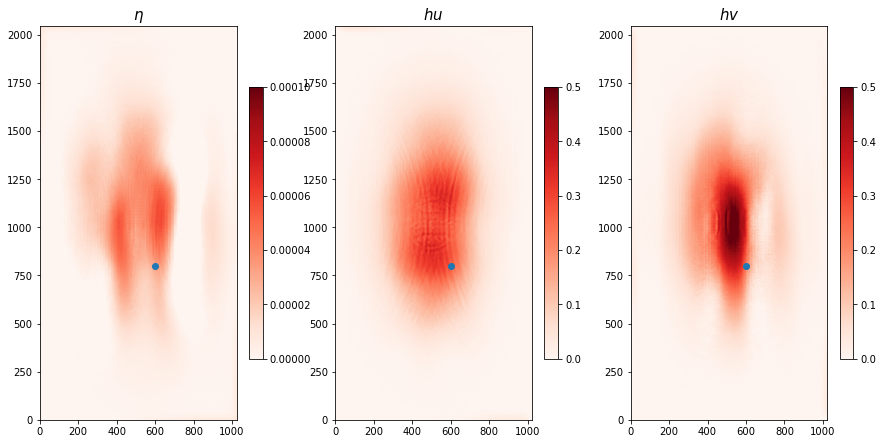

In [32]:
def MLvar(state):
    MLest_var = np.zeros(state[-1][0].shape[:-1])
    MLest_var += np.var(state[0], axis=-1).repeat(2**(ls[-1]-ls[0]),1).repeat(2**(ls[-1]-ls[0]),2)

    for l_idx, l in enumerate(ls):
        if l_idx > 0: 
            MLest_var += (np.var(state[l_idx][0], axis=-1) - np.var(state[l_idx][1],axis=-1).repeat(2,1).repeat(2,2)).repeat(2**(ls[-1]-l),1).repeat(2**(ls[-1]-l),2)
    
    return MLest_var

fig, axs = imshow3var(MLvar(ML_final_state))
axs[0].scatter(Hx, Hy)
axs[1].scatter(Hx, Hy)
axs[2].scatter(Hx, Hy)

In [33]:
def SLcdf4true(truth, Hx, Hy, SL_ensemble, SL_final_state):
    true_eta, true_hu, true_hv = truth.download(interior_domain_only=True)
    true_values = np.array([true_eta[Hy, Hx], true_hu[Hy, Hx], true_hv[Hy, Hx]])

    SL_Fy = np.sum(SL_final_state[:,Hy,Hx,:] < true_values[:,np.newaxis], axis=1)/SL_Ne    

    return SL_Fy

In [34]:
SL_Fy = SLcdf4true(truth, Hx, Hy, SL_ensemble, SL_final_state)
SL_Fy

array([1.  , 0.5 , 0.25])